In [19]:
import torch
import torchvision
import PIL
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
#7.1.1  Downloading CIFAR-10
from torchvision import datasets

data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) #下载太慢请开代理

16.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%

Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


In [4]:
# 堆栈的方式查看cifar10的父类
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [5]:
# dataset 必须实现两个方法， implement two methods: __len__ and __getitem__.
len(cifar10)

50000

In [21]:
img, label = cifar10[99]

img, label

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F811D7FCC50>, 1)

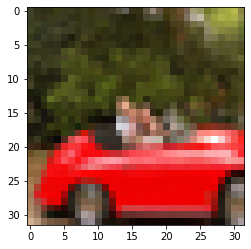

In [17]:
plt.imshow(img)
plt.show()

In [26]:
#7.1.3 Dataset transforms
# convert the PIL image to a PyTorch tensor, 把PIL图像转化成tensor

from torchvision import transforms
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [27]:
to_tensor = transforms.ToTensor()

img_t = to_tensor(img)
img_t.shape #3 channels and 32*32 pixels, label没变仍热是数值

torch.Size([3, 32, 32])

In [28]:
#简化操作，一步转化
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                    transform=transforms.ToTensor())

In [29]:
img_t, _ = tensor_cifar10[99]
type(img_t) #查看类型，确实转化为tensor

torch.Tensor

In [30]:
img_t.shape, img_t.dtype #torch默认采用float32加速计算

(torch.Size([3, 32, 32]), torch.float32)

In [31]:
# 原始PIL图像像素0-255通过tensor转化scale到[0,1]
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

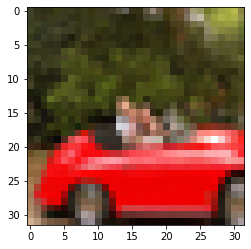

In [32]:
plt.imshow(img_t.permute(1, 2, 0)) #将tensor矩阵通道维度放到最后

plt.show() #确认是同一张照片

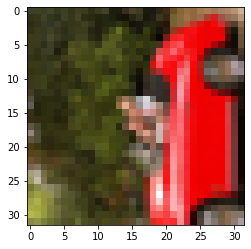

In [35]:
plt.imshow(img_t.permute(2,1,0)) #行列维度颠倒输出图片

In [36]:
#7.1.4 Normalizing data 数据标准化处理
# 为了数值稳定性，将输入数据分布的期望和标准差做scale
# 先引入额外维度将所有tensor堆叠
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [42]:
imgs.view(3, -1) #当某一维是-1时，会自动计算它的大小，相当于将 3*32*32 转为 3*1024

tensor([[0.2314, 0.6039, 1.0000,  ..., 0.0471, 0.7647, 0.6392],
        [0.2431, 0.6941, 1.0000,  ..., 0.1216, 0.7451, 0.6392],
        [0.2471, 0.7333, 1.0000,  ..., 0.1961, 0.6706, 0.6314]])

In [37]:
# compute the mean per channel计算每个通道的均值(也就是待修正的期望)
imgs.view(3, -1).mean(dim=1) #按第一个维度求均值，对于每一个通道1024向量求均值

tensor([0.4914, 0.4822, 0.4465])

In [39]:
imgs.view(3, -1).std(dim=1) #同理计算每个通道的标准差

tensor([0.2470, 0.2435, 0.2616])

In [43]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [71]:
# 引入normalize的数据初始化
tensor_cifar10_normalize_train = datasets.CIFAR10(data_path, train=True, download=False,
                            transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                     (0.2470, 0.2435, 0.2616))
                            ]))

In [72]:
tensor_cifar10_normalize_val = datasets.CIFAR10(data_path, train=True, download=False,
                            transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                     (0.2470, 0.2435, 0.2616))
                            ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


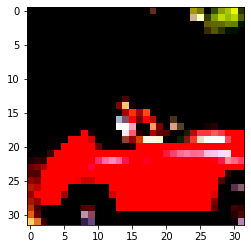

In [48]:
img_t, _ = tensor_cifar10_normalize[99]
# 此时图片数据scale到[0，1]，plt将其描绘成黑色，原始数据依然存在
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [74]:
# 7.2 Distinguishing birds from airplanes
# 7.2.1 Building the dataset

label_map = {0: 0, 2: 1} # 占位符
class_names = ['airplane', 'bird']
# 训练集
cifar2 = [(img, label_map[label])
    for img, label in tensor_cifar10_normalize_train
        if label in [0, 2]]
# 验证集
cifar2_val = [(img, label_map[label])
    for img, label in tensor_cifar10_normalize_val
        if label in [0, 2]]

In [84]:
cifar2

[(tensor([[[ 0.6139, -0.3228, -0.1164,  ..., -0.2593, -0.2752, -0.5451],
           [ 0.6615, -0.1482, -0.8467,  ..., -0.3228, -0.3228, -0.5768],
           [ 0.2329,  0.2646, -0.1005,  ..., -0.3387, -0.6562, -0.7515],
           ...,
           [ 0.2170,  0.2646,  0.1535,  ..., -0.5768, -0.4498,  0.0106],
           [ 0.5980,  0.4393,  0.3281,  ..., -0.6404, -0.4340,  0.0265],
           [ 0.9156,  0.8044,  0.4551,  ..., -0.4975, -0.5451, -0.0529]],
  
          [[ 1.3369,  0.2740,  0.4028,  ...,  0.3867,  0.3867,  0.0968],
           [ 1.4497,  0.5961, -0.2253,  ...,  0.3062,  0.3062,  0.0646],
           [ 1.0954,  1.1276,  0.6444,  ...,  0.2579, -0.0481, -0.1286],
           ...,
           [ 0.4028,  0.5156,  0.5317,  ...,  0.1774,  0.4028,  0.8538],
           [ 0.5478,  0.6605,  0.6605,  ...,  0.1130,  0.4028,  0.8860],
           [ 0.4834,  0.9504,  0.4995,  ...,  0.1774,  0.1613,  0.7572]],
  
          [[-0.4487, -0.7935, -0.1939,  ..., -0.6136, -0.6736, -0.8535],
           

In [55]:
print("{2:1}".format(10, 20, 30, 40))

30


In [61]:
# 7.2.2 FC model
# 构建一个单隐层全连接网络，激活函数采用tanh
import torch.nn as nn

n_out = 2
model = nn.Sequential(
        nn.Linear(3072,512,),
        nn.Tanh(),
        nn.Linear(512, n_out,)
        )

In [62]:
# 输出非线性激活函数softmax
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [63]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x) # 特点：大的更大，小的更小，进一步拉大距离

tensor([0.0900, 0.2447, 0.6652])

In [65]:
softmax(x).sum() # 确保归一化到总和为1

tensor(1.)

In [67]:
softmax = nn.Softmax(dim=1) #直接调用API，按第一个维度处理

x = torch.tensor([[1.0, 2.0, 3.0],
                [1.0, 2.0, 3.0]])

In [68]:
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [69]:
# 最终我们的模型
model_F = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


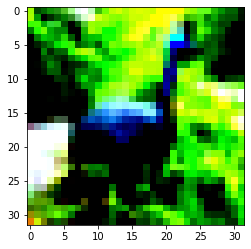

In [75]:
img, _ = cifar2[0]
# 查看bird
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [85]:
img.min(),img.max()

(tensor(-1.8629), tensor(2.0294))

In [76]:
img_batch = img.view(-1).unsqueeze(0) # 将所有输入数据拉成一行

In [78]:
img_batch

tensor([[ 0.6139, -0.3228, -0.1164,  ..., -1.2732, -1.3182, -1.0484]])

In [87]:
out = model(img_batch)
out #输出未作softmax

tensor([[ 0.3876, -0.3422]], grad_fn=<AddmmBackward>)

In [88]:
out = model_F(img_batch)
out #输出作softmax,转化为概率

tensor([[0.3590, 0.6410]], grad_fn=<SoftmaxBackward>)

In [91]:
out.shape

torch.Size([1, 2])

In [89]:
_, index = torch.max(out, dim=1)

index #按列维度求出最大参数对应的索引，显示结果the image is a bird.

tensor([1])

In [92]:
#7.2.5 分类问题的loss函数

#取log- softMax，转化loss为求最小
model_F2 = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1))

In [93]:
loss = nn.NLLLoss()

In [94]:
img, label = cifar2[0]
out = model_F2(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.6146, grad_fn=<NllLossBackward>)

In [97]:
# 7.2.6 Training the classifier
import torch
import torch.nn as nn
import torch.optim as optim

model_F3 = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1))
lr = 1e-2
optimizer = optim.SGD(model_F3.parameters(),lr =lr)
loss_fn = nn.NLLLoss()
#n_epochs = 100
n_epochs = 10

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model_F3(img.view(-1).unsqueeze(0))
        loss = loss_fn(out,torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 2.611546
Epoch: 1, Loss: 7.613807
Epoch: 2, Loss: 11.169825
Epoch: 3, Loss: 5.458175
Epoch: 4, Loss: 4.460520
Epoch: 5, Loss: 9.157469
Epoch: 6, Loss: 9.506369
Epoch: 7, Loss: 9.839945
Epoch: 8, Loss: 6.107517
Epoch: 9, Loss: 12.689064
